In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
## 글자 깨짐 방지를 위한 작업
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
# 폰트 설정

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

### 실거래가 기준 평균가격 그래프 생성

In [4]:
import glob # excel path list 생성을 위해 필요

In [5]:
# 빈 데이터 프레임 생성 / 각 월 별로 평균 값을 저장할 예정
# df_pre 데이터 프레임에 각 연월 별 평균값을 2개의 컬럼으로 저장하여 이 데이터를 그래프화 시킬 예정
df_pre = pd.DataFrame(columns=['year_month', 'mean'])

In [6]:
# content 내 excel 파일 검색
### 중요 ### // 다른 환경에서 작업 시, 이곳을 수정하여 excel이 저장되어있는 폴더 경로 지정 필요함
folder_path = '/content'
xlsx_files = glob.glob(f"{folder_path}/*.xlsx")

In [ ]:
for xlsx in xlsx_files:
    print(xlsx)
    numbers = re.findall(r'\d', xlsx)
    year_month = ''.join(numbers) # 해당 연, 월 String 변수 생성
    df = pd.read_excel(xlsx)
    df_need = df.drop(df.index[0:15]) # 데이터 프레임에서 필요한 부분만 축출
    new_header = df_need.iloc[0]
    new_header.name = ''
    df = df_need[1:]
    df.columns = new_header
    df = df.reset_index(drop=True)

    df = df[df['해제사유발생일'].isna()] ## 해제된 계약은 데이터에서 제외
    df = df.drop(columns=['해제사유발생일'])
    df['시군구'] = df['시군구'].str.split(' ') ## 구 단위로 평균값 축출
    df[['시', '구', '동']] = pd.DataFrame(df['시군구'].to_list())
    df = df.drop(columns=['시군구', '시', '동'])

    df['거래금액(만원)'] = df['거래금액(만원)'].str.replace(',','').astype(int)
    plt1 = df.groupby('구')['거래금액(만원)'].mean()
    mean = plt1.mean() # 평균 값 생성
    df_pre = df_pre.append({'year_month':year_month, 'mean':mean}, ignore_index=True) ## df_pre에 월과 평균값 저장 [연월, 평균값] 형태로 저장

In [8]:
df_pre   # 데이터가 날짜순으로 정렬되어있지 않음

,year_month,mean
0,201306,44739.909799
1,201412,44526.449940
2,201512,50322.911638
3,201906,77593.298071
4,202006,91765.790626
...,...,...
211,201912,80280.451710
212,202304,98891.329601
213,201403,44258.323577
214,202110,105670.588647


In [9]:
sort_df_pre = df_pre.sort_values(by='year_month', ignore_index=True) # 날짜 기준으로 데이터 정렬

In [10]:
sort_df_pre

,year_month,mean
0,200601,33963.458953
1,200602,34918.175455
2,200603,36035.590932
3,200604,34435.450121
4,200605,33452.568107
...,...,...
211,202308,105944.321494
212,202309,106555.659455
213,202310,104308.732849
214,202311,100086.186375


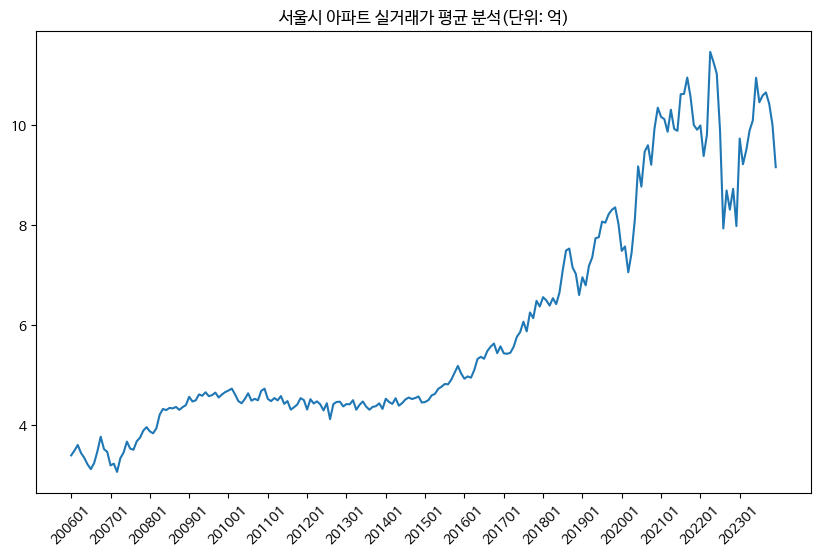

In [11]:
# 그래프 생성

plt.figure(figsize=(10,6))
plt.plot(sort_df_pre['year_month'], sort_df_pre['mean']/10000)

plt.title('서울시 아파트 실거래가 평균 분석(단위: 억)')

ticks = range(0, 216, 12)
plt.xticks(ticks, rotation=45)

plt.show()

### 시계열 분석

In [12]:
from prophet import Prophet

In [13]:
sort_df_pre.columns = ["ds", "y"]
sort_df_pre

,ds,y
0,200601,33963.458953
1,200602,34918.175455
2,200603,36035.590932
3,200604,34435.450121
4,200605,33452.568107
...,...,...
211,202308,105944.321494
212,202309,106555.659455
213,202310,104308.732849
214,202311,100086.186375


In [14]:
sort_df_pre["y"] = sort_df_pre["y"]/10000

In [15]:
sort_df_pre['ds'] = pd.to_datetime(sort_df_pre['ds'], format='%Y%m')

In [16]:
model = Prophet()
model.fit(sort_df_pre)

last_date = sort_df_pre['ds'].max()
future_dates = pd.date_range(start=last_date, periods=49, freq='MS')

future = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx2sojpyk/fzr0aqhd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx2sojpyk/kszydbfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91665', 'data', 'file=/tmp/tmpx2sojpyk/fzr0aqhd.json', 'init=/tmp/tmpx2sojpyk/kszydbfl.json', 'output', 'file=/tmp/tmpx2sojpyk/prophet_modelfoah1uea/prophet_model-20240104061133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


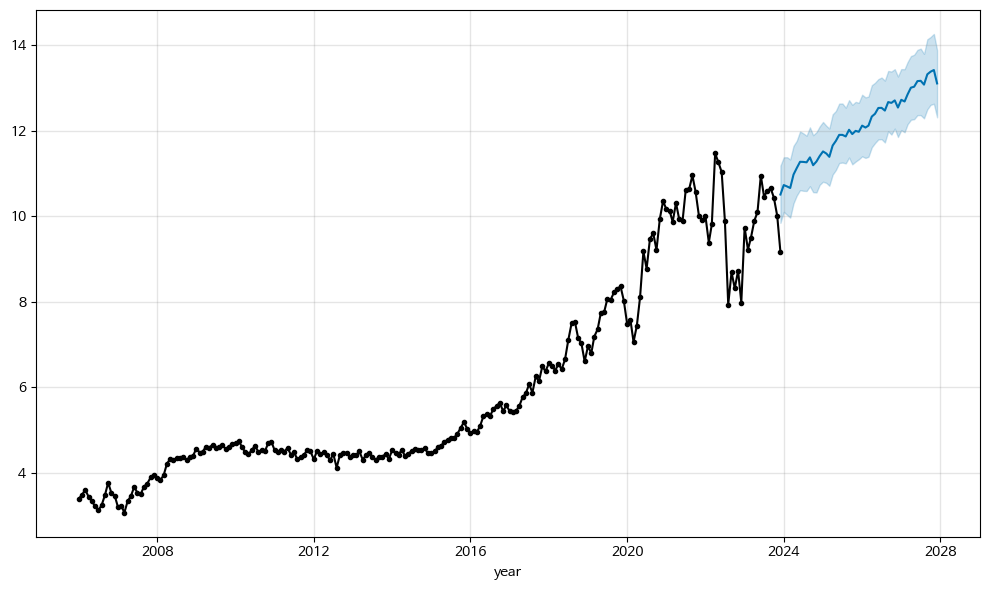

In [17]:
fig = model.plot(forecast, xlabel='year', ylabel='')
plt.plot(sort_df_pre['ds'], sort_df_pre['y'], color='black')